# STRING

In [19]:
import pandas as pd

# Create a Dataframe of a Protein-Protein-Network

# Load STRING Protein-Protein Interaction (PPI) data and mapping file
ppi = pd.read_csv("raw_data/PPI/9606.protein.links.v12.0.txt.gz", sep=" ")
gene_name = pd.read_csv("raw_data/PPI/protein2gene.csv", sep='\t')

# Remove species prefix "9606." from ENSP IDs in PPI dataset
ppi["protein1"] = ppi["protein1"].str.replace("9606.", "", regex=False)
ppi["protein2"] = ppi["protein2"].str.replace("9606.", "", regex=False)

# Rename columns for clarity
gene_name = gene_name.rename(columns={"protein_ENSP": "protein", "gene name": "gene"})

# Map protein1 (source) to gene names using the gene_name lookup table
ppi = ppi.merge(gene_name, how="left", left_on="protein1", right_on="protein")
ppi = ppi.rename(columns={"gene": "source"})
ppi = ppi.drop(columns=["protein"])  # Remove redundant column after merge

# Map protein2 (target) to gene names using the same lookup table
ppi = ppi.merge(gene_name, how="left", left_on="protein2", right_on="protein")
ppi = ppi.rename(columns={"gene": "target"})
ppi = ppi.drop(columns=["protein"])  # Remove redundant column after merge


In [20]:
# Keep only relevant columns: source and target gene names
ppi = ppi[["source", "target", "combined_score"]]

# Filter out rows where either source or target gene is missing ("Not Found")
mask = (ppi['source'] != 'Not Found') & (ppi['target'] != 'Not Found')
final_ppi_string = ppi[mask]


print("Final Dataframe:")
print(final_ppi_string.head())

Final Dataframe:
  source    target  combined_score
0   ARF5   RALGPS2             173
1   ARF5     FHDC1             154
2   ARF5  ATP6V1E1             151
4   ARF5      PSD3             201
5   ARF5     TTC9C             180


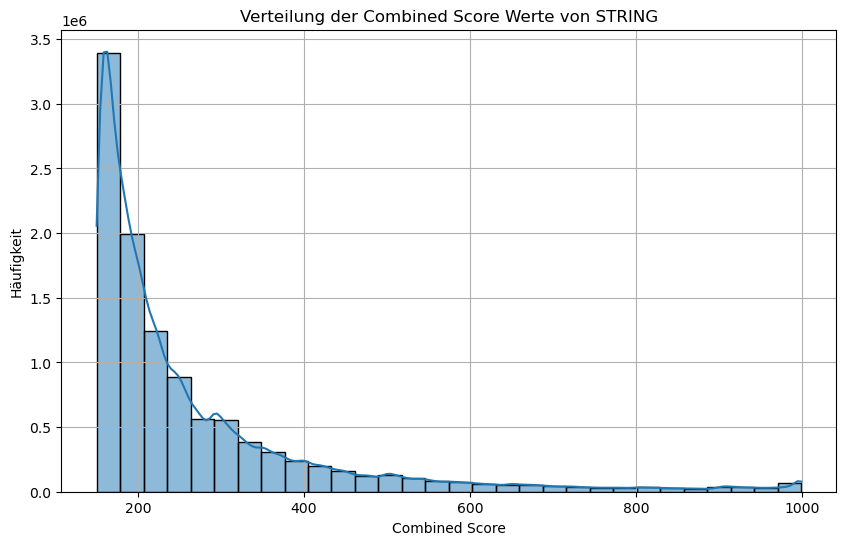

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verteilung der 'combined_score'-Spalte plotten
plt.figure(figsize=(10, 6))
sns.histplot(final_ppi_string['combined_score'], bins=30, kde=True)

plt.title('Verteilung der Combined Score Werte von STRING')
plt.xlabel('Combined Score')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()


In [7]:
median = final_ppi_string['combined_score'].median()
quantil_75 = final_ppi_string['combined_score'].quantile(0.75)
print(f"Median: {median}")
print(f"75% Quantil: {quantil_75}")

Median: 209.0
75% Quantil: 298.0


In [6]:
for t in [300, 500, 700]:
    print(f"Anzahl der Interaktionen bei Threshold {t}:")
    print(final_ppi_string[final_ppi_string['combined_score'] >= t].shape[0])

Anzahl der Interaktionen bei Threshold 300:
2717590
Anzahl der Interaktionen bei Threshold 500:
902484
Anzahl der Interaktionen bei Threshold 700:
374914


# IntAct

In [5]:
import re # for regular expressions (RegEx)
import pandas as pd # for Dataframe

# Functios to preprocess files
def extract_uniprotkb(text):
    """
    Extracts the UniProtKB identifier from a string.

    Parameters:
    - text: A string containing the UniProtKB ID.

    Returns:
    - string: The extracted UniProtKB ID or the original text if no ID is found.
    """
    match = re.search(r'uniprotkb:([A-Z0-9]+)', text)
    return match.group(1) if match else text

def extract_intact_miscore(text):
    """
    Extracts the Confidence value(s) (MI-Score) from a string.

    Parameters:
    - text: A string containing the MI-Score.

    Returns:
    - string: The extracted Confidence value(s) or the original text if no ID is found.
    """
    match = re.search(r'intact-miscore:([0-9.]+)', text)
    return float(match.group(1)) if match else None

def process_df(df):
    """
    Processes a DataFrame by extracting relevant information and applying functions to specific columns.

    Parameters:
    - df: A pandas DataFrame containing columns 'Protein', 'Interactor', 'Confidence value(s)', 'Database'.

    Returns:
    - pd.DataFrame: A processed DataFrame with additional columns for taxa and names.
    """
    df['Protein'] = df['#ID(s) interactor A'].apply(extract_uniprotkb)
    df['Interactor'] = df['ID(s) interactor B'].apply(extract_uniprotkb)
    df['intact_miscore'] = df['Confidence value(s)'].apply(extract_intact_miscore)
    df['Database'] = 'IntAct'
    return df

In [6]:
# IntAct
# Download human.txt (https://www.ebi.ac.uk/intact/interactomes for homo sapiens miTab 2.7) 
# file_path_IntAct = "/sybig/home/tmu/Schreibtisch/Thesis/Networks/data/PPI/IntAct/human.txt"
file_path_IntAct = "/Users/tm03/Desktop/Uni/Softwarepraktikum/Softwarepraktikum_local/Encoding/PPI/Aktuell/human.txt"
IntAct_df = pd.read_csv(file_path_IntAct, sep="\t")


In [7]:
IntAct_df = process_df(IntAct_df)
selected_columns = ['Protein', 'Interactor', 'intact_miscore', 'Database']
IntAct_df = IntAct_df[selected_columns]
IntAct_df.rename(columns={"intact_miscore" : "combined_score"}, inplace=True)
print(IntAct_df.head())

# Missing Values?

missing_values = IntAct_df.isnull().sum()
strich_values = (IntAct_df == '-').sum()

print("Missing values (NaN):")
print(missing_values)

# Missing values: 81 for intact_miscore

print("\nMissing values ('-'):")
print(strich_values)

# Missing values: 204 for interactor

# Drop rows with missing value
IntAct_df_cleaned = IntAct_df[~(IntAct_df[['Protein', 'Interactor']] == '-').any(axis=1)]

  Protein Interactor  combined_score Database
0  P46109     Q13191            0.62   IntAct
1  Q13191     P46109            0.62   IntAct
2  P61769     P01899            0.44   IntAct
3  P36897     P62942            0.59   IntAct
4  F1MRS1     A6H772            0.52   IntAct
Missing values (NaN):
Protein            0
Interactor         0
combined_score    81
Database           0
dtype: int64

Missing values ('-'):
Protein             0
Interactor        204
combined_score      0
Database            0
dtype: int64


In [8]:
## Mapping

import pandas as pd
import requests
import time
from tqdm import tqdm
import numpy as np

unique_uniprot_ids = pd.concat([IntAct_df_cleaned['Protein'], IntAct_df_cleaned['Interactor']]).dropna().unique()

# Konvertiere zuerst zu einer Liste oder numpy array
unique_uniprot_list = unique_uniprot_ids.tolist()

# Filtere alle Einträge, die NICHT mit 'intact:' beginnen
filtered_uniprot_list = [uid for uid in unique_uniprot_list if not uid.startswith('intact:')]

# Optional: wieder als numpy.ndarray (falls gewünscht)
filtered_uniprot_ids = np.array(filtered_uniprot_list)


unique_uniprot_df = pd.DataFrame({'UniProt_ID': filtered_uniprot_ids})
unique_uniprot_df.to_csv('unique_uniprot_ids.csv', index=False)


In [9]:
import pandas as pd

# Laden deiner Dateien
file_path = "/Users/tm03/Desktop/TUGDA_1/data_network/output.csv"
test = pd.read_csv(file_path, sep="\t")

# Rename-Spalte, damit wir eindeutige Namen haben
test = test.rename(columns={'UniProt_ID': 'Protein_ID', 'gene name': 'Gene_Name'})

# Mappen der Gene Names
IntAct_df_cleaned = IntAct_df_cleaned.merge(test, left_on='Protein', right_on='Protein_ID', how='left')
IntAct_df_cleaned = IntAct_df_cleaned.rename(columns={'Gene_Name': 'source'})
IntAct_df_cleaned = IntAct_df_cleaned.drop(columns='Protein_ID')

IntAct_df_cleaned = IntAct_df_cleaned.merge(test, left_on='Interactor', right_on='Protein_ID', how='left')
IntAct_df_cleaned = IntAct_df_cleaned.rename(columns={'Gene_Name': 'target'})
IntAct_df_cleaned = IntAct_df_cleaned.drop(columns='Protein_ID')

# Ergebnis
print(IntAct_df_cleaned.head())

  Protein Interactor  combined_score Database     source     target
0  P46109     Q13191            0.62   IntAct       CRKL       CBLB
1  Q13191     P46109            0.62   IntAct       CBLB       CRKL
2  P61769     P01899            0.44   IntAct        B2M  Not Found
3  P36897     P62942            0.59   IntAct     TGFBR1     FKBP1A
4  F1MRS1     A6H772            0.52   IntAct  Not Found  Not Found


In [11]:
# Keep only relevant columns: source and target gene names
IntAct_df_cleaned = IntAct_df_cleaned[["source", "target", "combined_score"]]
IntAct_df_cleaned['combined_score'] = IntAct_df_cleaned['combined_score'] * 1000

# Filter out rows where either source or target gene is missing ("Not Found")
mask = (IntAct_df_cleaned['source'] != 'Not Found') & (IntAct_df_cleaned['target'] != 'Not Found')
final_ppi_intact = IntAct_df_cleaned[mask]


print("Final Dataframe:")
print(final_ppi_intact.head())

final_ppi_intact.to_csv('final_ppi_intact.csv', index=False)


Final Dataframe:
   source  target  combined_score
0    CRKL    CBLB           620.0
1    CBLB    CRKL           620.0
3  TGFBR1  FKBP1A           590.0
7  PPP4R1     NaN           400.0
8     CSK   IGF1R           570.0


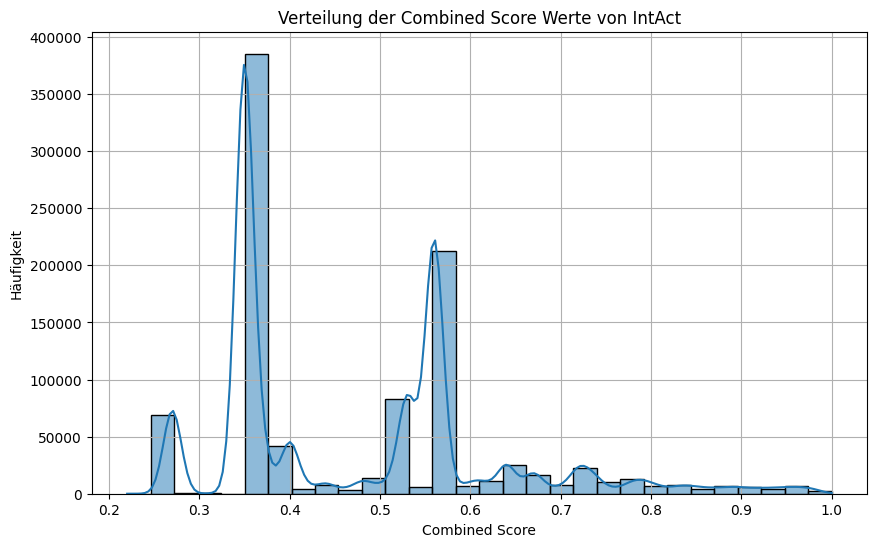

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verteilung der 'combined_score'-Spalte plotten
plt.figure(figsize=(10, 6))
sns.histplot(final_ppi_intact['Score'], bins=30, kde=True)

plt.title('Verteilung der Combined Score Werte von IntAct')
plt.xlabel('Combined Score')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()


In [16]:
median = final_ppi_intact['Score'].median()
quantil_75 = final_ppi_intact['Score'].quantile(0.75)
print(f"Median: {median}")
print(f"75% Quantil: {quantil_75}")

Median: 0.4
75% Quantil: 0.56


In [17]:
for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
    print(f"Anzahl der Interaktionen bei Threshold {t}:")
    print(final_ppi_intact[final_ppi_intact['Score'] >= t].shape[0])

Anzahl der Interaktionen bei Threshold 0.3:
916160
Anzahl der Interaktionen bei Threshold 0.4:
530234
Anzahl der Interaktionen bei Threshold 0.5:
462212
Anzahl der Interaktionen bei Threshold 0.6:
154717
Anzahl der Interaktionen bei Threshold 0.7:
96824


# Threshold definieren

In [4]:
import pandas as pd
from itertools import product

# Daten laden
ppi_df_STRING = pd.read_csv("./data/final_PPI_String.csv")
ppi_df_IntAct = pd.read_csv("./data/final_ppi_IntAct.csv")

# Load the full GDSC dataset (FPKM + AUC values for all drugs)
gdsc_dataset = pd.read_csv('/Users/tm03/Desktop/TUGDA_1/data/GDSCDA_fpkm_AUC_all_drugs.zip', index_col=0)

# - First 1780 columns correspond to gene expression data
gene_list = gdsc_dataset.columns[0:1780]

def filter_ppi_by_gene_list(ppi_df, gene_list):
    return ppi_df[
        (ppi_df['source'].isin(gene_list)) &
        (ppi_df['target'].isin(gene_list))
    ]

# Filter anwenden
ppi_df_STRING = filter_ppi_by_gene_list(ppi_df_STRING, gene_list)
ppi_df_IntAct = filter_ppi_by_gene_list(ppi_df_IntAct, gene_list)

# Thresholds definieren
string_thresholds = [300, 500, 700]
intact_thresholds = [0.3, 0.5, 0.7]

# Funktion zur Normalisierung der Kanten (A-B == B-A)
def get_edge_set(df):
    df = df[['source', 'target']].astype(str)  # Alles in Strings umwandeln
    return set(tuple(sorted(row)) for row in df.values)

# Ergebnisse speichern
results = []

# Schleife über alle Threshold-Kombinationen
for string_t, intact_t in product(string_thresholds, intact_thresholds):
    
    # Filtern
    string_filtered = ppi_df_STRING[ppi_df_STRING['combined_score'] >= string_t]
    intact_filtered = ppi_df_IntAct[ppi_df_IntAct['Score'] >= intact_t]
    
    # Sets erstellen
    string_edges = get_edge_set(string_filtered)
    intact_edges = get_edge_set(intact_filtered)
    
    # Gemeinsame Kanten
    common_edges = string_edges.intersection(intact_edges)
    
    # Speichern
    results.append({
        'string_threshold': string_t,
        'intact_threshold': intact_t,
        'string_count': len(string_edges),
        'intact_count': len(intact_edges),
        'common_count': len(common_edges)
    })

# Ergebnisse als DataFrame ausgeben
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 string_threshold  intact_threshold  string_count  intact_count  common_count
              300               0.3         82317         15517          6708
              300               0.5         82317          4575          2815
              300               0.7         82317          1106           831
              500               0.3         36101         15517          4508
              500               0.5         36101          4575          2313
              500               0.7         36101          1106           814
              700               0.3         17292         15517          3310
              700               0.5         17292          4575          1903
              700               0.7         17292          1106           780
